In [1]:
import multiprocessing as mp
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

2024-12-07 23:40:12.634491: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 23:40:12.635490: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-07 23:40:12.642356: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-07 23:40:12.664062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733607612.698689   19484 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733607612.71

In [2]:
df = pd.read_csv("/home/aleks/studies/data-mining-project/input/data_merged.csv")

/tmp/ipykernel_19484/1854379116.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/aleks/studies/data-mining-project/input/data_merged.csv")


In [4]:
# columns = [
#     'City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
#     'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket',
#     'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex...6',
#     'uvIndex...7', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
#     'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
#     'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
#     'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'hour_of_day',
#     'hour_cos', 'hour_sin', 'hour_2_cos', 'hour_2_sin', 'day_of_week',
#     'month_of_year', 'winddir_cos', 'winddir_sin', 'windspeed_x',
#     'windspeed_y', 'precipMM_cumsum_24h', 'windspeedKmph_cumsum_24h'
# ]

In [5]:
feature_columns = [
    'hour_cos',
    'hour_sin',
    'hour_2_cos',
    'hour_2_sin',
    'winddir_cos',
    'winddir_sin',
    'windspeed_x',
    'windspeed_y',
    'windspeedKmph',
    # 'WindGustKmph',
    # 'DewPointC',
    # 'FeelsLikeC',
    # 'HeatIndexC',
    # 'WindChillC',
    'tempC',
    'cloudcover',
    'humidity',
    'precipMM',
    'pressure',
    'winddirDegree',
    # 'maxtempC',
    # 'mintempC',
    'sunHour',
    # 'moon_illumination',
    # 'uvIndex...6',
    'uvIndex...7',
    'precipMM_cumsum_24h',
    'windspeedKmph_cumsum_24h',
]
#     'hour_of_day',
#     'month_of_year',
#     'day_of_week',
#     'totalSnow_cm',
#     'sunrise', 'sunset',
#     'moonrise', 'moonset',

In [31]:
r2_scores = []

for city, df_city in df.groupby("City"):
    print(city)

    for response_variable in ["CO", "NH3", "NOx", "O3", "PM10", "PM2.5", "SO2"]:
        train_mask = df_city["Datetime"] < "2019-01-01"
        df_input = df_city[feature_columns + [response_variable]].dropna()
        df_train = df_input.loc[train_mask]
        df_val = df_input.loc[~train_mask]

        if len(df_train) == 0 or len(df_val) == 0:
            continue

        model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(shape=(len(feature_columns),)),
            tf.keras.layers.Dense(
                16,
                activation="leaky_relu",
                kernel_regularizer=tf.keras.regularizers.l1(0.05),
            ),
            tf.keras.layers.Dense(
                1,
                activation="relu",
                # kernel_regularizer=tf.keras.regularizers.l1(0.1),
            )
        ])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(0.005),
            loss="mean_squared_error",
        )

        n_epochs = max(6, round(150000 / len(df_train)))
        history = model.fit(
            df_train[feature_columns],
            df_train[response_variable],
            batch_size=256,
            shuffle=True,
            validation_data=(df_val[feature_columns], df_val[response_variable]),
            validation_batch_size=256,
            epochs=n_epochs,
        )
        val_pred = model.predict(df_val[feature_columns], batch_size=256, verbose=0).flatten()
        r = np.corrcoef(df_val[response_variable], val_pred)[0, 1]
        r2 = r**2
        rmse = np.sqrt(np.mean((df_val[response_variable] - val_pred)**2))

        feature_importance = model.layers[0].get_weights()[0] #* model.layers[1].get_weights()[0].T

        r2_scores.append({
            "City": city,
            "Response": response_variable,
            "R": r,
            "R2": r2,
            "RMSE": rmse,
            "Feature_importance": feature_importance,
            "History": history.history,
        })
        print(f"{response_variable}: {round(r2, 3)} ({round(rmse, 3)})")

Bengaluru
Epoch 1/6
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0781 - val_loss: 0.0412
Epoch 2/6
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2872 - val_loss: 0.0403
Epoch 3/6
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2908 - val_loss: 0.0399
Epoch 4/6
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2825 - val_loss: 0.0413
Epoch 5/6
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3004 - val_loss: 0.0373
Epoch 6/6
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2976 - val_loss: 0.0373
CO: 0.288 (0.153)
Epoch 1/6
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.1057 - val_loss: 1.2580
Epoch 2/6
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1715 - val_loss: 0.4719
Epoch 3/6
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5707 - val_loss: 0.2700
Epoch 4/6
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4057 - val_loss: 0.1601
Epoch 5/6
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3755 - val_loss: 0.1962
Epoch 6/6
108/108 ━━━━━━━━━━━━━━━━━━━

In [32]:
# 16 hidden nodes
df_r2 = pd.DataFrame(r2_scores)
df_r2.groupby("Response")[["RMSE", "R", "R2"]].mean()

,RMSE,R,R2
Response,,,
CO,0.287055,0.427492,0.216440
NH3,0.417419,0.276916,0.135207
NOx,0.590715,0.526945,0.295617
O3,0.622545,0.647206,0.428975
PM10,0.417229,0.733320,0.542804
PM2.5,0.456570,0.738527,0.552001
SO2,0.403527,0.313583,0.106454


In [30]:
# 4 hidden nodes
df_r2 = pd.DataFrame(r2_scores)
df_r2.groupby("Response")[["RMSE", "R", "R2"]].mean()

,RMSE,R,R2
Response,,,
CO,0.328810,0.507721,0.263144
NH3,0.415165,0.301761,0.136825
NOx,0.574158,0.569777,0.336385
O3,0.613450,0.658105,0.448487
PM10,0.453290,0.689187,0.480036
PM2.5,0.454967,0.733162,0.544457
SO2,0.399964,0.288569,0.097774


In [ ]:
# 1 hidden node
df_r2 = pd.DataFrame(r2_scores)
df_r2.groupby("Response")[["RMSE", "R2"]].mean()

,RMSE,R2
Response,,
CO,0.291894,0.215232
NH3,0.504208,0.303448
NOx,0.858814,0.456592
O3,0.735209,0.487260
PM10,1.097272,0.529043
PM2.5,0.651833,0.633230
SO2,0.406106,0.290994


In [21]:
df_r2 = pd.DataFrame(r2_scores)
df_r2.groupby("Response")[["RMSE", "R2"]].mean()

,RMSE,R2
Response,,
CO,0.291955,0.294756


In [56]:
df_r2.History.apply(lambda x: x["loss"][-1]).mean(), df_r2.History.apply(lambda x: x["val_loss"][-1]).mean()

(0.6943314279265264, 0.7250503070981187)

In [33]:
df_r2 = pd.DataFrame(r2_scores)
df_r2["R2"].mean()

0.5122715222032383

In [39]:
df_r2.History.apply(lambda x: x["loss"][-1]).mean(), df_r2.History.apply(lambda x: x["val_loss"][-1]).mean()

(0.4393947797224802, 0.3798856781247784)

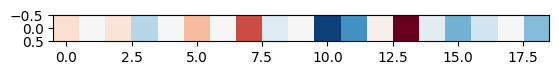

In [46]:
plt.imshow(
    df_r2[df_r2["R2"] > 0.83]["Feature_importance"].values[0].T,
    cmap="RdBu_r",
    vmin=-0.1,
    vmax=0.1,
)

In [47]:
df_r2[["City", "Response", "R2"]]

,City,Response,R2
0,Bengaluru,CO,0.499962
1,Bengaluru,NH3,-0.097610
2,Bengaluru,NOx,0.483552
3,Bengaluru,O3,0.708764
4,Bengaluru,PM10,0.301338
5,Bengaluru,PM2.5,0.578805
6,Bengaluru,SO2,0.128063
7,Delhi,CO,0.417843
8,Delhi,NH3,0.508272
9,Delhi,NOx,0.734362


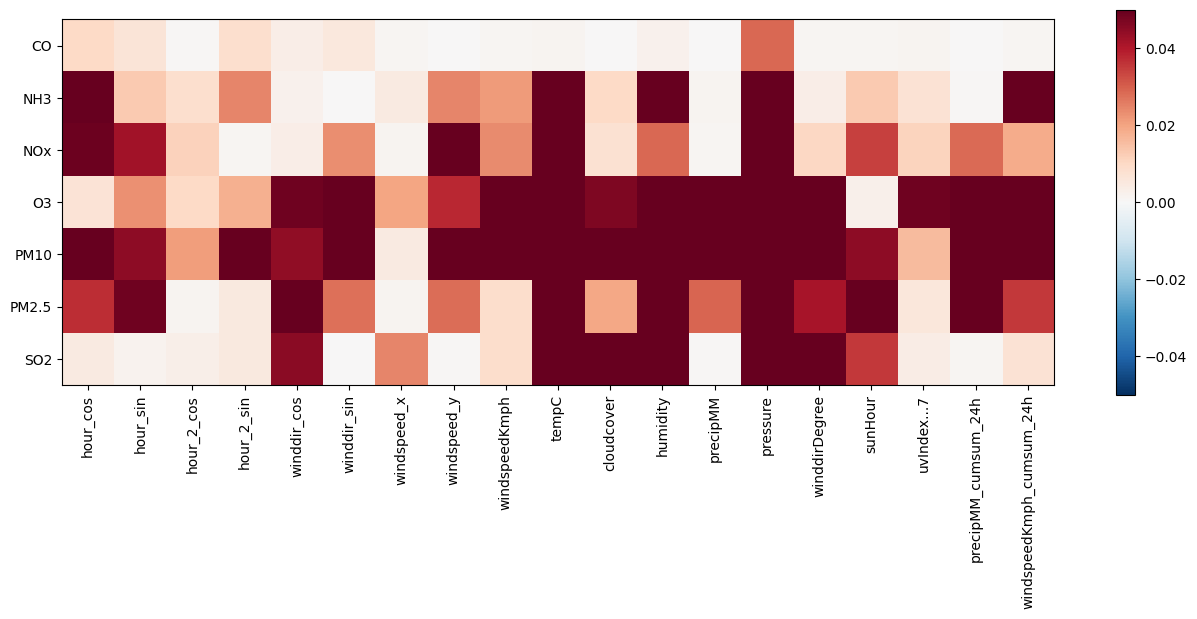

In [64]:
plt.figure(figsize=(16, 5))
plt.imshow(
    np.array(
        [*df_r2.groupby("Response")["Feature_importance"].mean().apply(lambda x: np.abs(x).max(axis=1)).values]
    ),
    cmap="RdBu_r",
    vmin=-0.05,
    vmax=0.05,
)
plt.xticks(range(len(feature_columns)), feature_columns, rotation=90)
plt.yticks(range(7), df_r2["Response"].drop_duplicates().values)
plt.colorbar()
plt.show()

In [52]:
df_r2.groupby("Response")["R2"].mean()

Response
CO       0.462598
NH3      0.243959
NOx      0.563655
O3       0.497723
PM10     0.503436
PM2.5    0.627192
SO2      0.258338
Name: R2, dtype: float64

In [53]:
df_r2.groupby("City")["R2"].mean()

City
Bengaluru    0.371839
Delhi        0.506694
Hyderabad    0.599977
Jaipur       0.408677
Mumbai       0.388373
Name: R2, dtype: float64

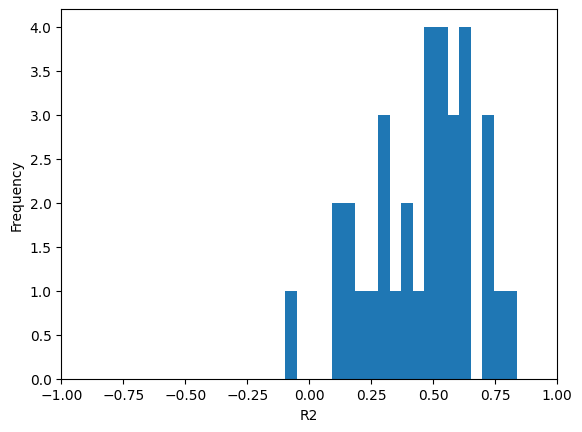

In [54]:
plt.hist(
    df_r2["R2"],
    bins=20,
)
plt.xlabel("R2")
plt.xlim(-1, 1)
plt.ylabel("Frequency")
plt.show()

Bengaluru CO 0.5


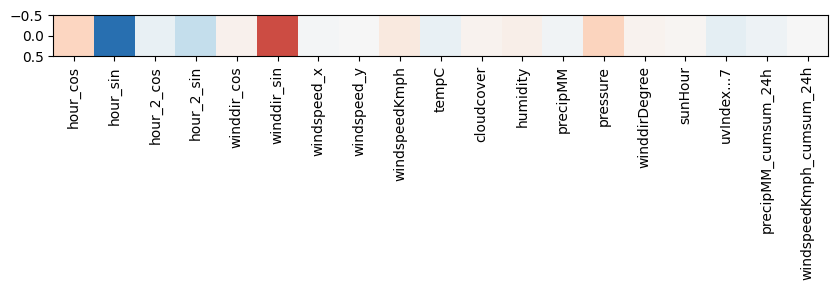

Delhi CO 0.418


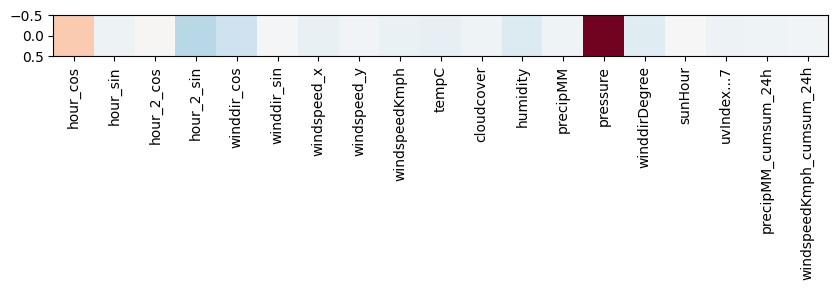

Hyderabad CO 0.537


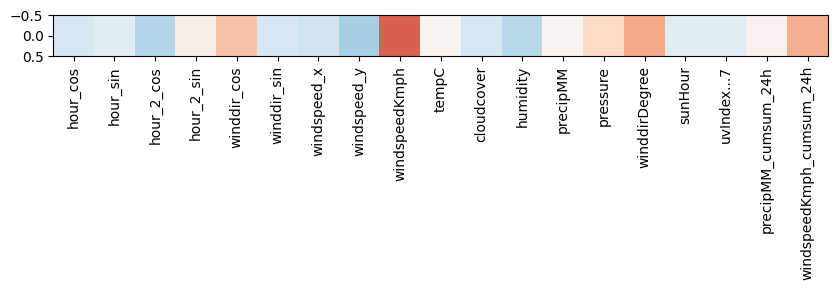

Jaipur CO 0.283


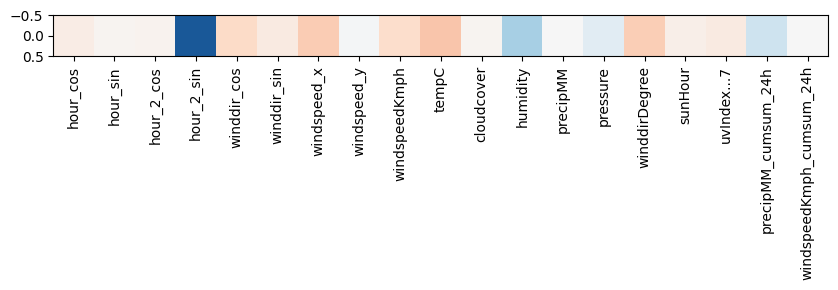

Mumbai CO 0.575


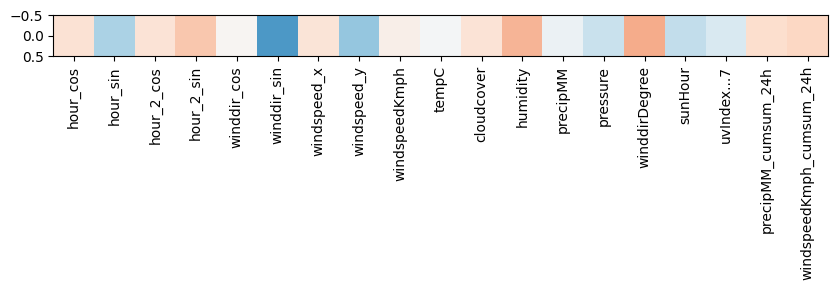

Bengaluru NH3 -0.098


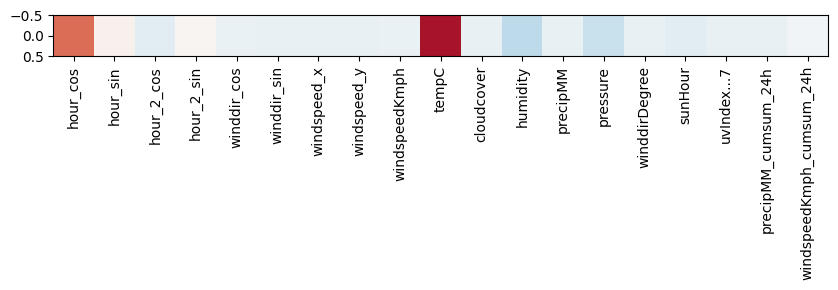

Delhi NH3 0.508


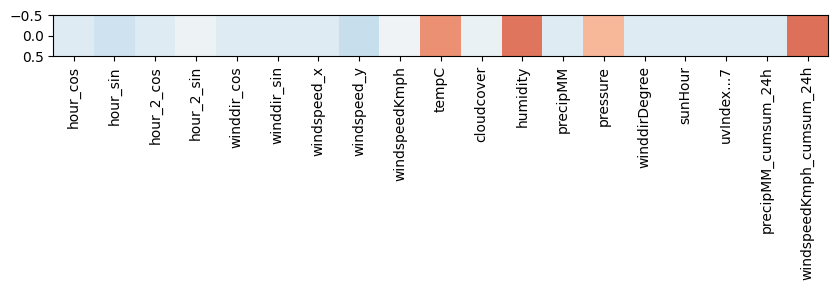

Hyderabad NH3 0.399


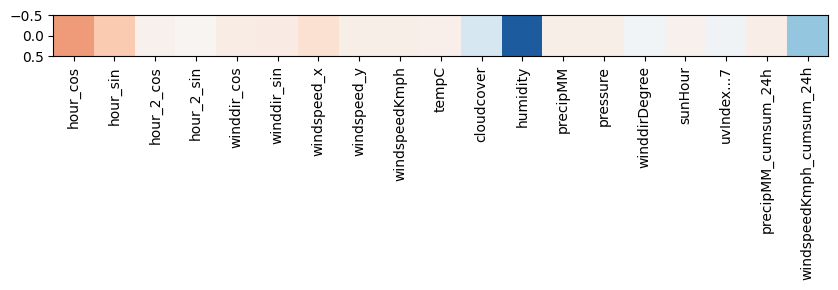

Jaipur NH3 0.166


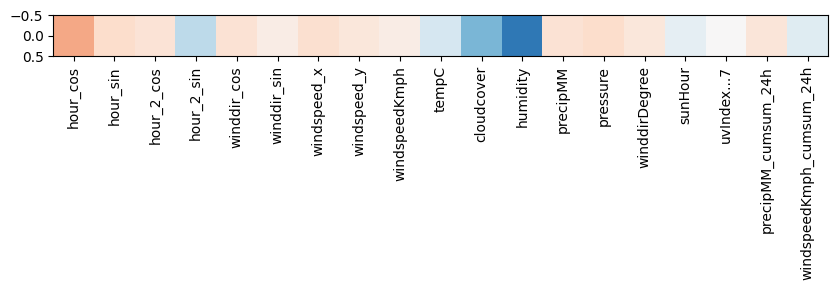

Bengaluru NOx 0.484


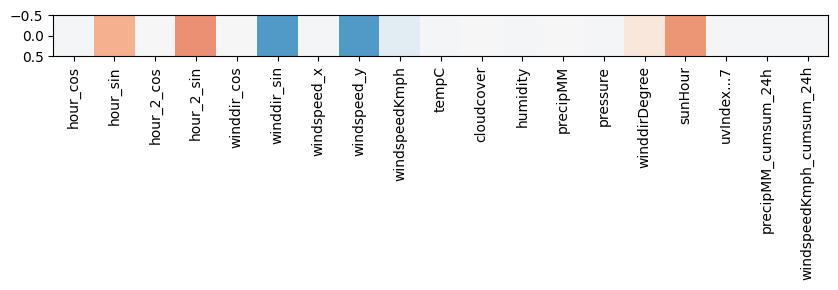

Delhi NOx 0.734


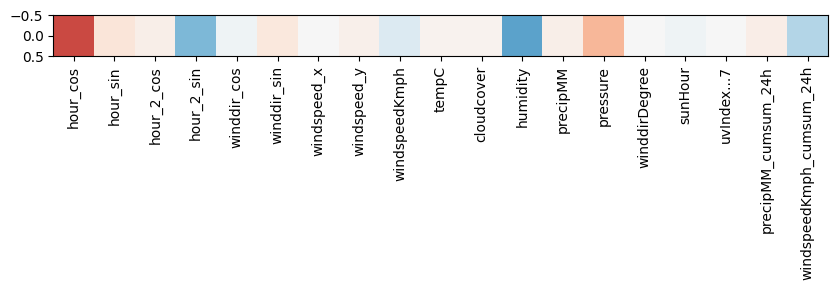

Hyderabad NOx 0.612


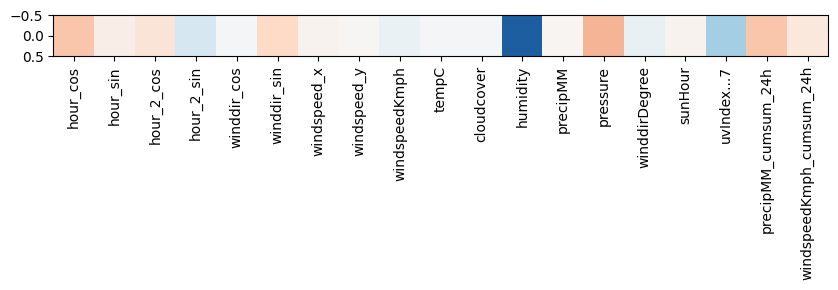

Jaipur NOx 0.629


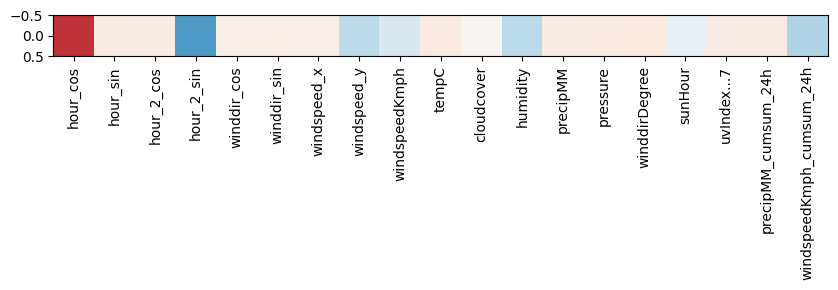

Mumbai NOx 0.359


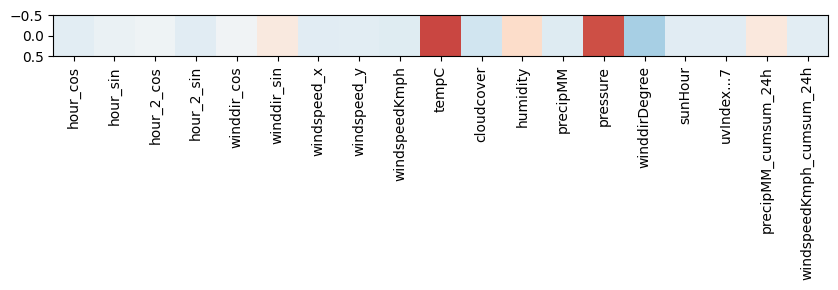

Bengaluru O3 0.709


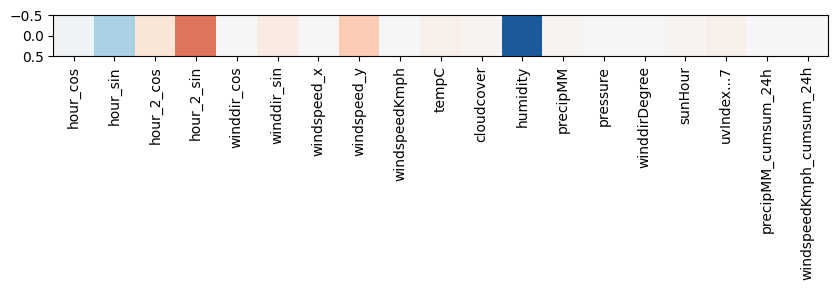

Delhi O3 0.242


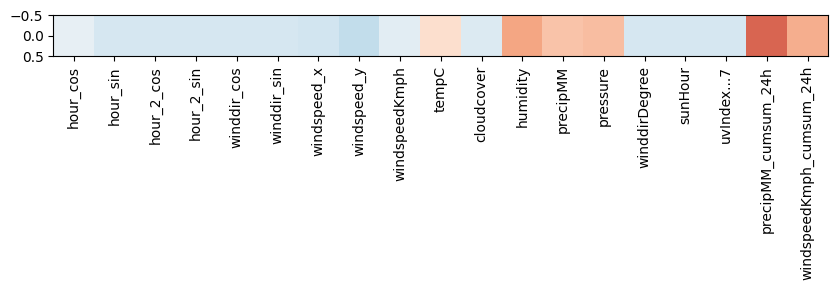

Hyderabad O3 0.763


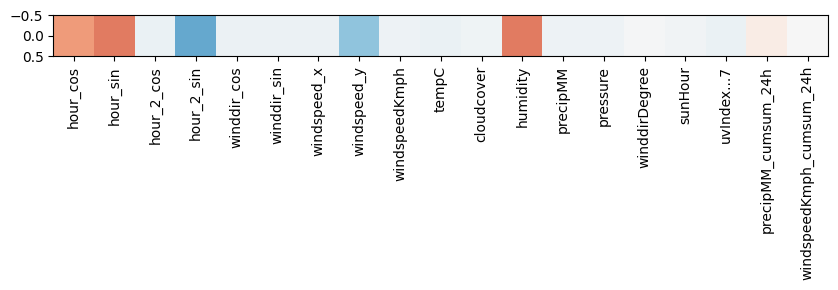

Jaipur O3 0.639


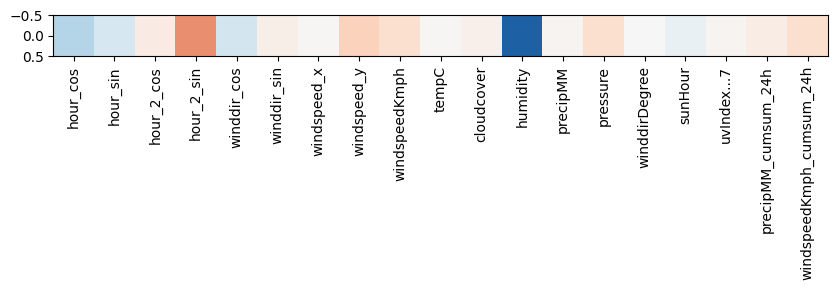

Mumbai O3 0.135


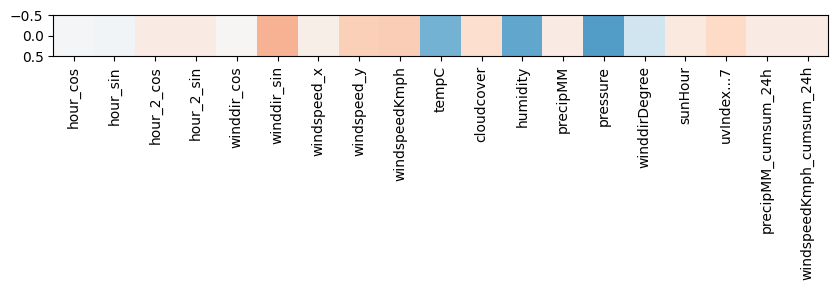

Bengaluru PM10 0.301


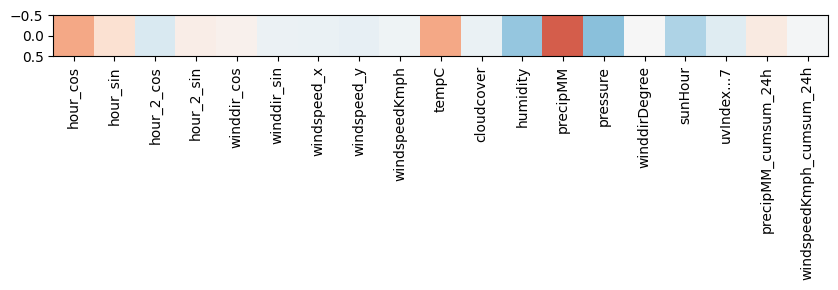

Delhi PM10 0.544


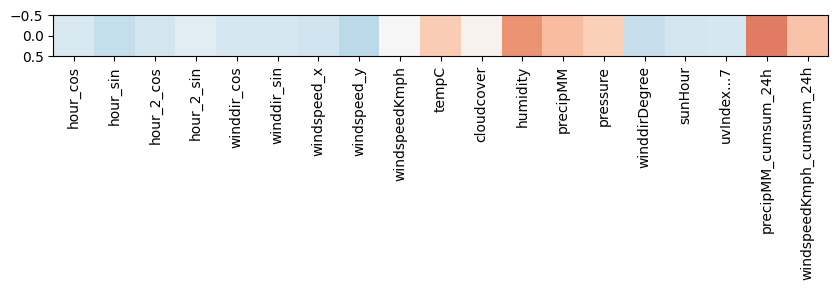

Hyderabad PM10 0.744


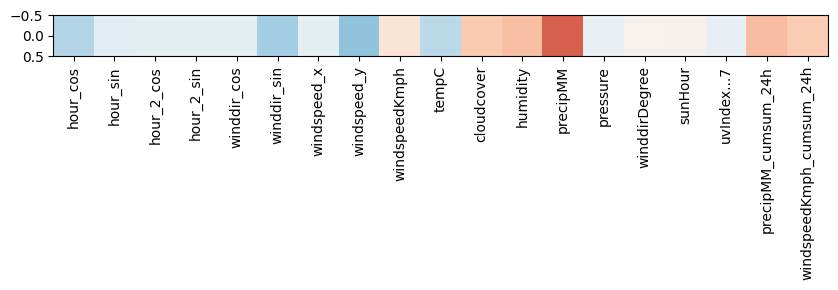

Jaipur PM10 0.416


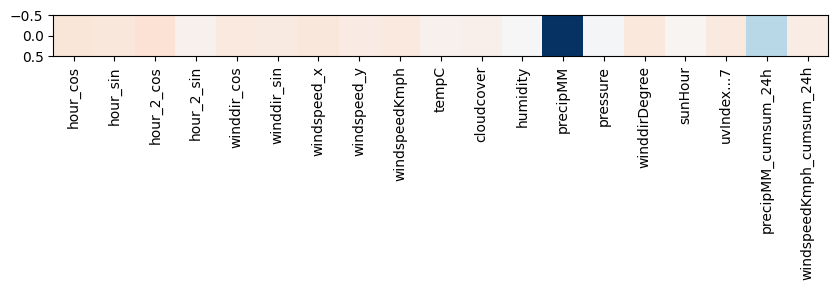

Mumbai PM10 0.511


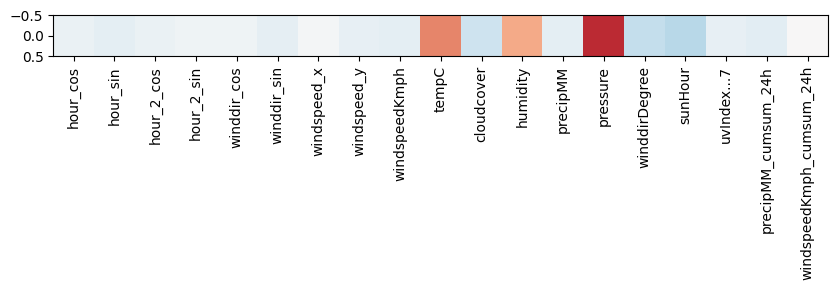

Bengaluru PM2.5 0.579


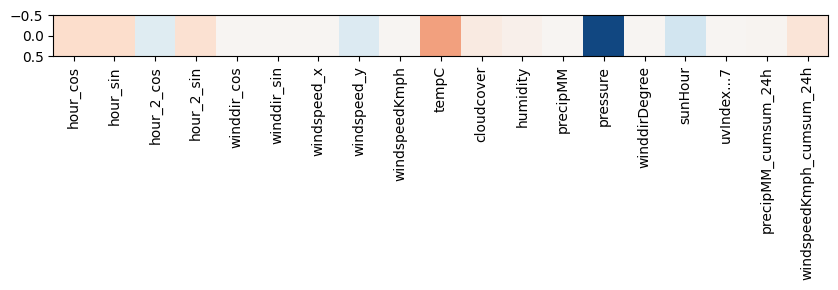

Delhi PM2.5 0.63


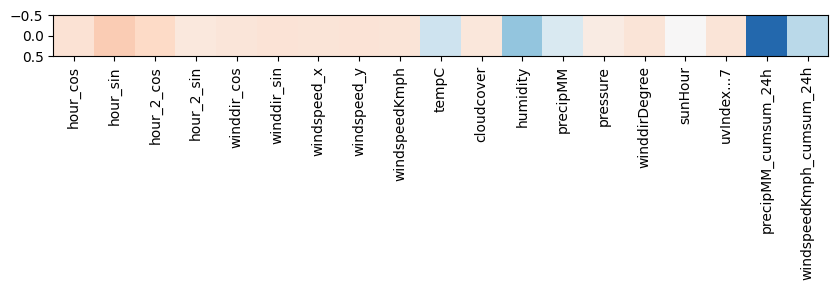

Hyderabad PM2.5 0.839


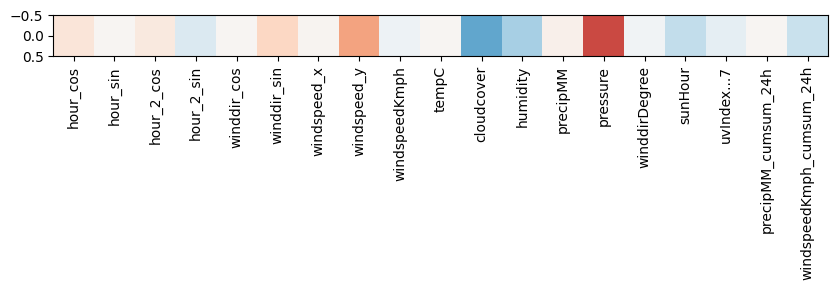

Jaipur PM2.5 0.517


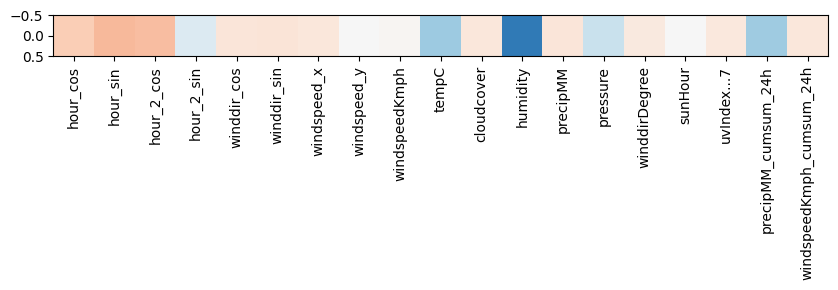

Mumbai PM2.5 0.571


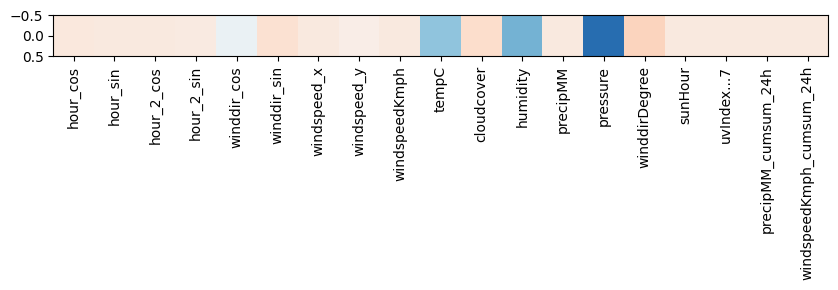

Bengaluru SO2 0.128


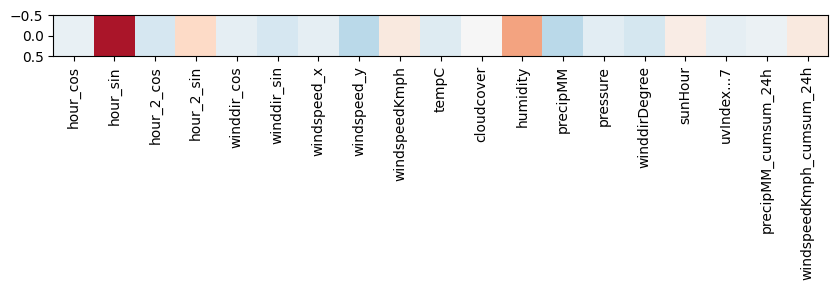

Delhi SO2 0.47


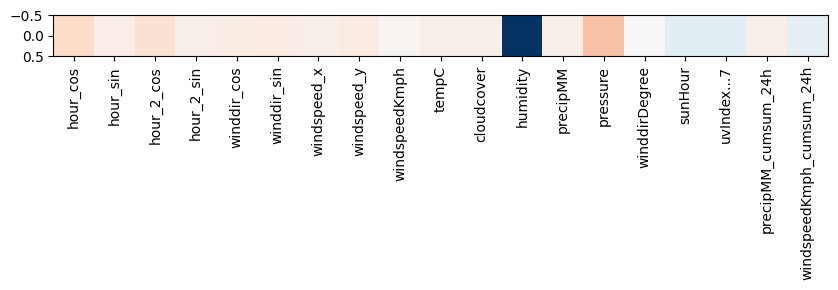

Hyderabad SO2 0.305


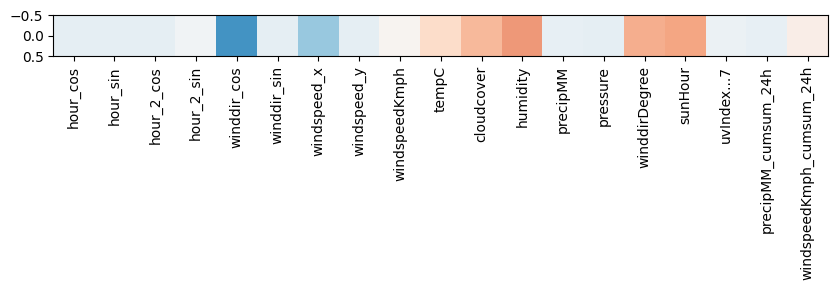

Jaipur SO2 0.21


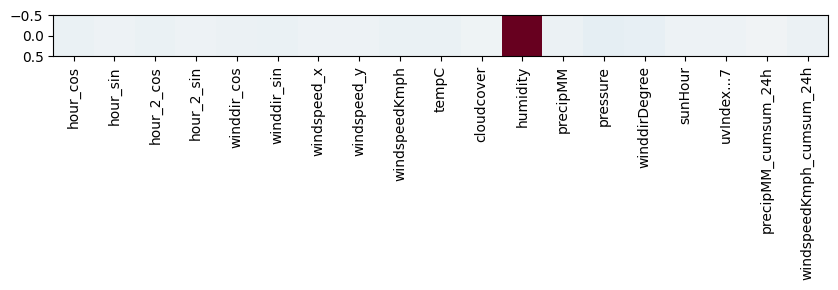

Mumbai SO2 0.179


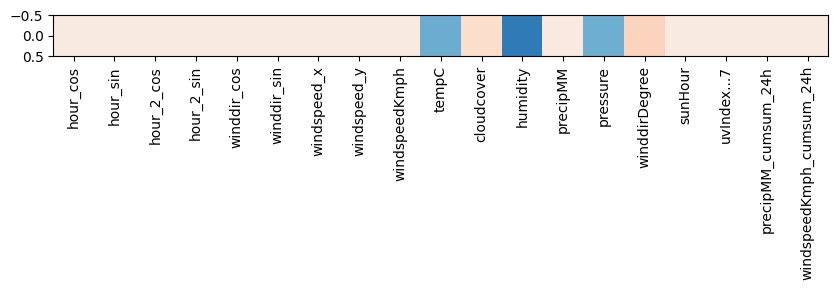

In [55]:
def scale_rows(x):
    return (x - x.mean(axis=0)) / x.std(axis=0)


for row in df_r2.sort_values(["Response", "City"]).itertuples():
    print(row.City, row.Response, round(row.R2, 3))
    plt.figure(figsize=(10, 3))
    plt.imshow(
        scale_rows(row.Feature_importance).T,
        cmap="RdBu_r",
        vmin=-4,
        vmax=4,
    )
    plt.xticks(range(len(feature_columns)), feature_columns, rotation=90)
    plt.show()

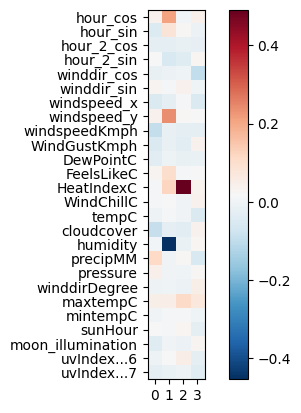

In [ ]:
feature_importance = model.layers[0].get_weights()[0] / np.abs(model.layers[0].get_weights()[0]).sum(axis=0) * model.layers[1].get_weights()[0].T
# * model.layers[1].get_weights()[0].T

plt.imshow(feature_importance, cmap="RdBu_r")
plt.xticks(range(len(model.layers[0].get_weights()[0].T)))
plt.yticks(range(len(feature_columns)), feature_columns, rotation=0)
plt.colorbar()
plt.show()